In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import pickle
import cv2
import numpy as np
np.random.seed(0)
import itertools
import tensorflow as tf
tf.compat.v1.set_random_seed(0)
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import callbacks 
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [2]:
data_path = 'C:/Users/nehal/Downloads/datast/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/'
train_data = data_path+'train'
valid_data = data_path+'valid'

In [3]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [4]:
train_gen = train_datagen.flow_from_directory(
    train_data,
    target_size=(256, 256),
    batch_size=64,
    class_mode='sparse'
)
test_gen = test_datagen.flow_from_directory(
    valid_data,
    target_size=(256, 256),
    batch_size=64,
    class_mode='sparse'
)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [5]:
# Define model with regularization and transfer learning
base_model = keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)

for layer in base_model.layers[:-4]:
    layer.trainable = False

model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(38, activation='softmax')
])

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 38)                38950     
                                                                 
Total params: 3,608,678
Trainable params: 1,763,494
Non-

In [6]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath='/kaggle/working/model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

history = model.fit(train_gen, validation_data=test_gen, epochs=15, callbacks=my_callbacks)

Epoch 1/15
1099/1099 [==============================] - 8780s 8s/step - loss: 0.6833 - accuracy: 0.8066 - val_loss: 0.2598 - val_accuracy: 0.9162
Epoch 2/15
1099/1099 [==============================] - 7594s 7s/step - loss: 0.2512 - accuracy: 0.9202 - val_loss: 0.1665 - val_accuracy: 0.9445
Epoch 3/15
1099/1099 [==============================] - 4317s 4s/step - loss: 0.1861 - accuracy: 0.9390 - val_loss: 0.1467 - val_accuracy: 0.9501
Epoch 4/15
1099/1099 [==============================] - 11068s 10s/step - loss: 0.1524 - accuracy: 0.9493 - val_loss: 0.1263 - val_accuracy: 0.9574
Epoch 5/15
1099/1099 [==============================] - 9962s 9s/step - loss: 0.1309 - accuracy: 0.9556 - val_loss: 0.1131 - val_accuracy: 0.9623
Epoch 6/15
1099/1099 [==============================] - 2639s 2s/step - loss: 0.1192 - accuracy: 0.9598 - val_loss: 0.1003 - val_accuracy: 0.9657
Epoch 7/15
1099/1099 [==============================] - 2362s 2s/step - loss: 0.1057 - accuracy: 0.9642 - val_loss: 0.1075

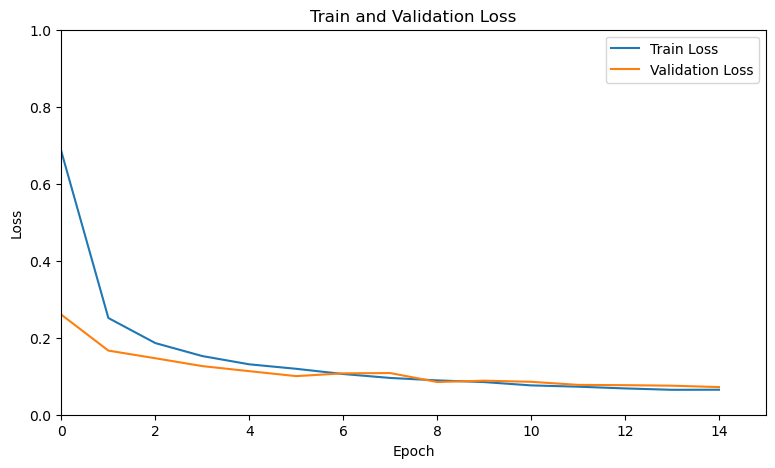

In [35]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 15)
plt.ylim(0.0,1.0)
plt.legend()



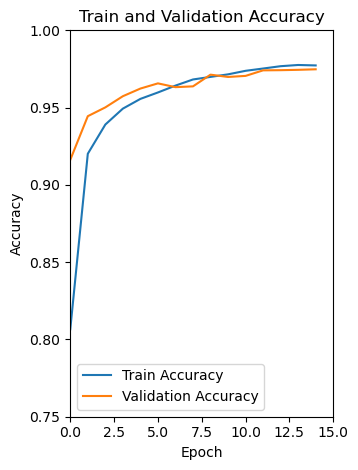

In [36]:
plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 15)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

# Save the figures
plt.savefig('train_val_loss_accuracy.png')

In [23]:
train_loss, train_accuracy = model.evaluate(train_gen)
print(f"Train Accuracy: {train_accuracy}")

# Get test accuracy
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy}")



1099/1099 [==============================] - 2248s 2s/step - loss: 0.0386 - accuracy: 0.9869
Train Accuracy: 0.9869264960289001
275/275 [==============================] - 374s 1s/step - loss: 0.0718 - accuracy: 0.9748
Test Accuracy: 0.9747894406318665


In [28]:
# Get predictions for precision and recall calculation
y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)



275/275 [==============================] - 390s 1s/step


In [ ]:
# Calculate precision and recall scores
precision = precision_score(labels, predictions, average='micro')
recall = recall_score(labels, predictions, average='micro')

print(f"Precision Score: {precision}")
print(f"Recall Score: {recall}")

In [34]:
labels = []
predictions = []
for x,y in test_gen:
    labels.append(list(y_true))
    predictions.append(list(y_pred))

MemoryError: Unable to allocate 48.0 MiB for an array with shape (64, 256, 256, 3) and data type float32

In [ ]:
print(f"Train Accuracy: {train_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Precision Score: {precision*100:.2f}%")
print(f"Recall Score: {recall*100:.2f}%")

In [ ]:
plt.figure(figsize= (20,5))
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(1,39)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,colorbar= False,cmap = 'YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix.png')
plt.show()